In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import codecs
import json
import os
import sys
import glob as glob
import numpy as np
import datetime
import cv2
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
import tensorflow
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.utils import img_to_array, load_img
import tensorflow as tf

In [2]:
# default settings
img_width, img_height = 224, 224

train_dir = 'Dataset/train'
validate_dir = 'Dataset/test'
nb_epochs = 20
batch_size = 16
nb_classes = len(glob.glob(train_dir + '/*'))

nb_train_samples = sum(len(files) for _, _, files in os.walk(train_dir))
print(nb_train_samples)

nb_validate_samples = sum(len(files) for _, _, files in os.walk(validate_dir))
print(nb_validate_samples)

11003
969


In [3]:
# data pre-processing for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True
)

In [4]:
# data pre-processing for validation
validate_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True
)

In [5]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size
)

Found 10998 images belonging to 4 classes.


In [6]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size
)

Found 968 images belonging to 4 classes.


In [7]:
# Calculate class weight
total = len(validate_dir)
count_cnv = 2874
count_dme = 2760
count_drusen = 2766
count_normal = 2598
cnv_weight = (1/count_cnv) * (total/4)
dme_weight = (1/count_dme) * (total/4)
drusen_weight = (1/count_drusen) * (total/4)
norm_weight = (1/count_normal) * (total/4)
class_weight = {0: cnv_weight, 1: dme_weight, 2: drusen_weight, 3: norm_weight}
print("Class Weights: 0CVN - 1DME - 2DRUSEN - 3NORMAL"  + str(class_weight))

Class Weights: 0CVN - 1DME - 2DRUSEN - 3NORMAL{0: 0.005306193458594294, 1: 0.00552536231884058, 2: 0.005513376717281272, 3: 0.005869899923017705}


In [8]:
# set up transfer learning on pre-trained ImageNet VGG16 model
# remove fully connected layer and replace with softmax for classifying nb_classes classes
vgg16_model = VGG16(weights='imagenet', include_top=False)
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation='softmax')(x)
model = Model(inputs=vgg16_model.input, outputs=predictions)

In [9]:
# freeze all layers of the pre-trained model
for layer in vgg16_model.layers:
    layer.trainable = False


In [10]:
# compile the new model using an RMSprop optimizer
model.compile(
    optimizer=RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [12]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit(
    train_generator,
    epochs=nb_epochs,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validate_generator,
    validation_steps=nb_validate_samples // batch_size,
    class_weight=class_weight
)


Epoch 1/20


2023-06-07 11:08:19.581399: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


687/687 [==============================] - 1505s 2s/step - loss: 0.0053 - accuracy: 0.5842 - val_loss: 0.5134 - val_accuracy: 0.8271
Epoch 2/20
687/687 [==============================] - 1602s 2s/step - loss: 0.0040 - accuracy: 0.7125 - val_loss: 0.4957 - val_accuracy: 0.8052
Epoch 3/20
687/687 [==============================] - 1619s 2s/step - loss: 0.0037 - accuracy: 0.7408 - val_loss: 0.4901 - val_accuracy: 0.8240
Epoch 4/20
687/687 [==============================] - 1534s 2s/step - loss: 0.0035 - accuracy: 0.7564 - val_loss: 0.4842 - val_accuracy: 0.8073
Epoch 5/20
687/687 [==============================] - 1617s 2s/step - loss: 0.0034 - accuracy: 0.7637 - val_loss: 0.3819 - val_accuracy: 0.8490
Epoch 6/20
687/687 [==============================] - 1639s 2s/step - loss: 0.0032 - accuracy: 0.7779 - val_loss: 0.4642 - val_accuracy: 0.8188
Epoch 7/20
687/687 [==============================] - 1637s 2s/step - loss: 0.0031 - accuracy: 0.7846 - val_loss: 0.3424 - val_accuracy: 0.8687
Epo

In [13]:
model.save("octvgg16.h5")
with open("octvgg16.json", "w") as f:
    json.dump(transfer_learning_history.history, f)

print('Training time: %s' % (now() - t))

Training time: 9:00:12.144265


In [14]:
# evaluate the performance the new model and report the results
score = model.evaluate(
    validate_generator, steps=nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

60/60 [==============================] - 135s 2s/step - loss: 0.2767 - accuracy: 0.8957
Test Score: 0.2767447531223297
Test Accuracy: 0.8956611752510071


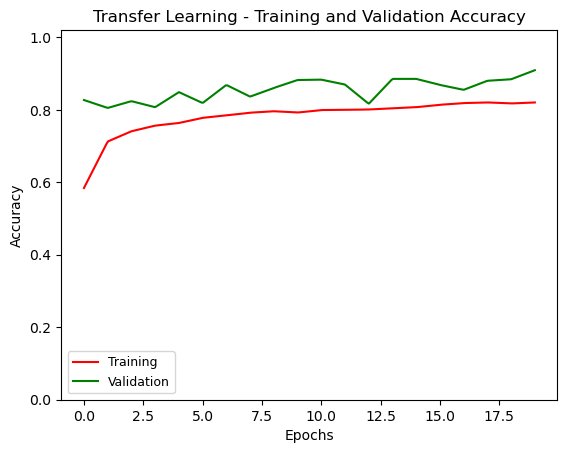

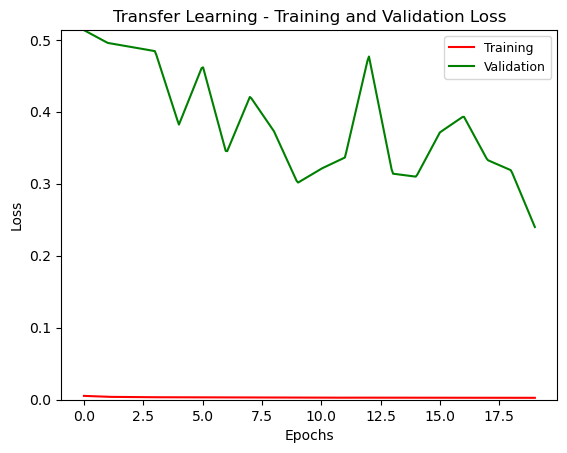

In [15]:
xfer_acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = interp1d(x, y, kind='linear')(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label='Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = interp1d(x1, y1, kind='linear')(x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label='Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.legend(loc='lower left', fontsize=9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1.02)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = interp1d(x, y, kind='linear')(x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label='Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = interp1d(x1, y1, kind='linear')(x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label='Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.legend(loc='upper right', fontsize=9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, max(y1))
plt.show()

61/61 [==============================] - 145s 2s/step
Found 968 files belonging to 4 classes.


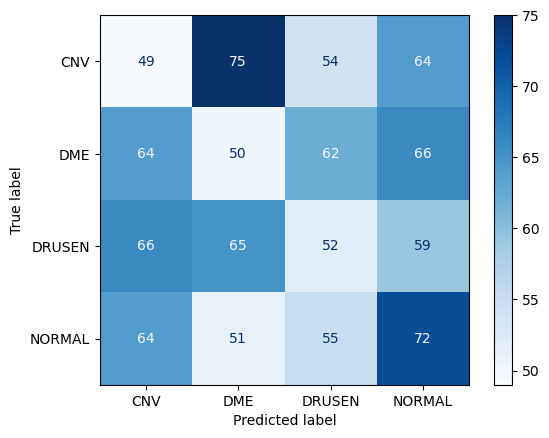

In [16]:
predictions = model.predict(validate_generator)
# Convert prediction probabilities into integers
predictions = np.argmax(predictions, axis=1)

class_labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

class_names = class_labels

test = tf.keras.preprocessing.image_dataset_from_directory(
    validate_dir,
    labels='inferred',
    image_size=(224, 224),
    batch_size=16,
    color_mode='rgb',
)
test_labels = [labels for _, labels in test.unbatch()]

cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [17]:

print(validate_generator.total_batches_seen)


1345
